In [1]:
import torch
import numpy as np

# To plot
import matplotlib.pyplot as plt
import seaborn as sns

# Custom library
from mcmc import ULA, MALA
from function import MODEL

## A density to sample from

First, we design a density to sample from using pyTorch. Here we create functions so that one can sample from a multidimensional Gaussian distribution.

We also compute (up to a multiplicative constant which is absorbed in the gradient step) the gradient of the log-density.

In [2]:
def log_gradient_gaussian(mu, cov):
    def gradient(x): return - cov @ (x - mu)
    return gradient


def gaussian_torch(mu, sigma):
    def pdf(x):
        return torch.exp(- (x-mu) @ sigma @ (x - mu))
    return pdf

### Utility functions

Below one can find some utility functions used to plot interesting features.

- Kernel denisty estimation along some chosen axis.
- autocorrelation of generated samples

In [3]:
def auto_correlation(M, kappa=100):
    kappa = len(M) // kappa
    auto_corr = np.zeros((kappa-1, 2))
    mu = np.mean(M, axis=0)
    for s in range(1, kappa-1):
        auto_corr[s] = np.mean((M[:-s]-mu) * (M[s:]-mu),
                               axis=0) / np.var(M, axis=0)
    return auto_corr


def plot(points, x_axis=0, y_axis=1, kind="scatter",
         n_points=400, burnin=150):
    """
    { “scatter” | “kde” | “hex” }
    """
    sns.set()
    x = points[burnin:(burnin+n_points), x_axis]
    y = points[burnin:(burnin+n_points), y_axis]
    sns.jointplot(x, y, kind=kind)
    plt.show()
    plt.figure(figsize=(7, 7), linewidth=1)
    plt.plot(x[:n_points], y[:n_points])
    plt.title("Trajectory of the Markov Chain")
    plt.show()


def plot_autocorrelation(points, axis_list, kappa=100, legend=False):
    auto_corr = auto_correlation(points, kappa)
    plt.figure(figsize=(11, 8))
    for i in axis_list:
        plt.plot(auto_corr[1:, i], label=f"Axis : {i}")
    plt.title("Autocorrelation of the time serie (MCMC generated samples)")
    plt.show()

## Examples

First we use **MODEL** from `model.py` to create a distribution to sample from.

In [4]:
# - GAUSSIAN DISTRIBUTION EXAMPLE
MEAN = torch.zeros(2)
COV = torch.tensor([[1, .9], [.9, 1]])

# Create the model
GAUSSIAN_DENSITY = gaussian_torch(MEAN, COV)
GAUSSIAN_LOG_GRADIENT = log_gradient_gaussian(MEAN, COV)
GAUSSIAN = MODEL(density=GAUSSIAN_DENSITY,
                 log_density_gradient=GAUSSIAN_LOG_GRADIENT)

# Initial "sample" of the chain
INIT_POINT = 2 * torch.randn_like(MEAN) + 3

Then we can chose wich MCMC sampler to use. For instance, one can see that using **ULA** ( Unadjusted Langevin Algorithm), the autocorrelation is slowly decreasing. This is because one cannot increase exploration (`random_step`) too much using ULA. This algorithm does not converge to the target distribution but to another one that is close enough to the target one (in total variation norm for instance) given that the step parameters are small enough.

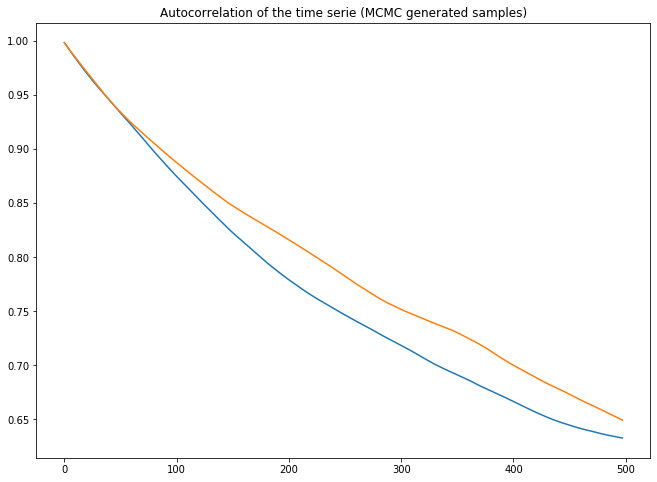

In [5]:
# -- ULA - GAUSSIAN

# Number of sample to generate
nbr_samples = 50000

# MCMC sampler initialization
ULA_GAUSSIAN = ULA(model=GAUSSIAN,
                   metric=torch.eye(2),
                   gradient_step=5e-3,
                   random_step=4e-1,
                   initialization=INIT_POINT)

# Generation of samples
points = ULA_GAUSSIAN.fit(nbr_samples)

# Plot
points = np.array(points)
# plot(points, burnin=0, n_points=nbr_samples-1)
# plot(points, burnin=200, n_points=nbr_samples-201)
plot_autocorrelation(points, [0, 1])

**MALA** (Metropolis Adjusted Langevin Algorithm) does converge to the target distribution and one can increase the exploration up to an acceptation ration of around 63%. This ratio is an empirical good choice regarding the speed of convergence and quality of the density estimation from samples.

Acceptation ratio : 0.6668267050758849


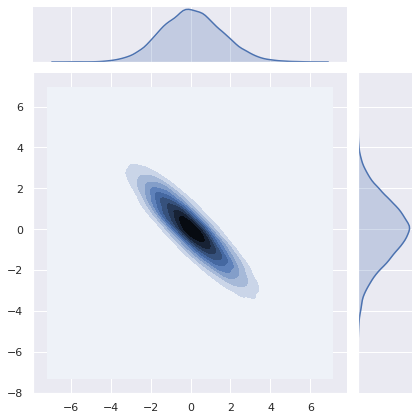

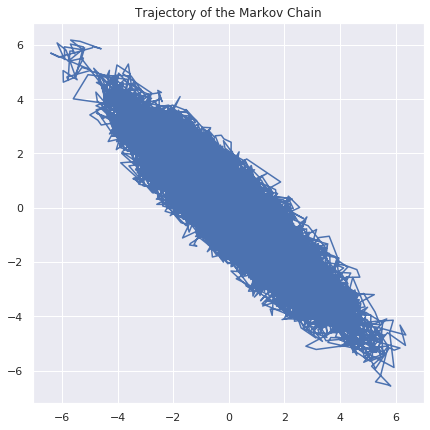

In [6]:
# -- MALA - GAUSSIAN

# Number of sample to generate
nbr_samples = 50000

# MCMC sampler initialization
MALA_GAUSSIAN = MALA(model=GAUSSIAN,
                     metric=torch.eye(2),
                     gradient_step=2e-2,
                     random_step=4e-1,
                     initialization=INIT_POINT)

# Generation of samples
points = MALA_GAUSSIAN.fit(nbr_samples)

# Plot - kde plot takes a few seconds
points = np.array(points)
# plot(points, burnin=0, n_points=nbr_samples-1)
plot(points, burnin=200, n_points=nbr_samples-201, kind='kde')

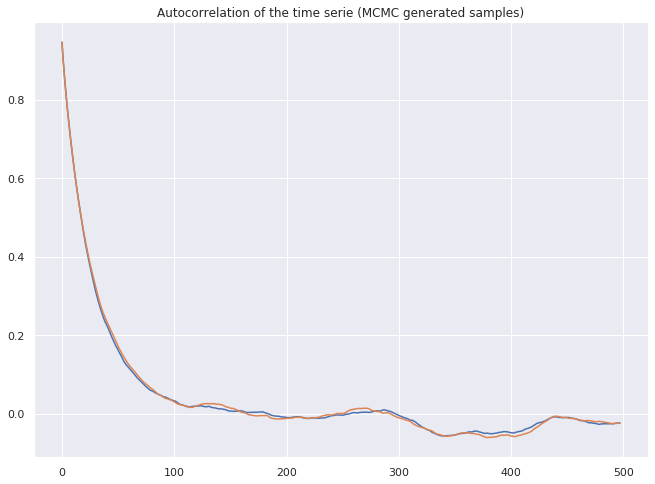

In [7]:
auto_corr = auto_correlation(points, 100)
plot_autocorrelation(points, [0, 1])

One can see that the behavior of this algorithm is better than simple ULA. However, this algorithm faces some difficulty regarding scalability and its application to large dimension distribution.

### Without the implemented gradient

For the sake of pedagogy, let's assume we cannot compute the gradient of the gaussian density. Then, we can rely on autodifferentiation to compute it.

In [8]:
# To avoid scrolling up, we duplicate some code here.

def gaussian_torch(mu, sigma):
    def pdf(x):
        return torch.exp(- (x-mu) @ sigma @ (x - mu))
    return pdf

# - GAUSSIAN DISTRIBUTION EXAMPLE
MEAN = torch.zeros(2)
COV = torch.tensor([[1, .9], [.9, 1]])

# Create the model - without known gradient
GAUSSIAN_DENSITY = gaussian_torch(MEAN, COV)
GAUSSIAN = MODEL(density=GAUSSIAN_DENSITY)

# Initial "sample" of the chain
INIT_POINT = 2 * torch.randn_like(MEAN) + 3

Acceptation ratio : 0.6200396825396826


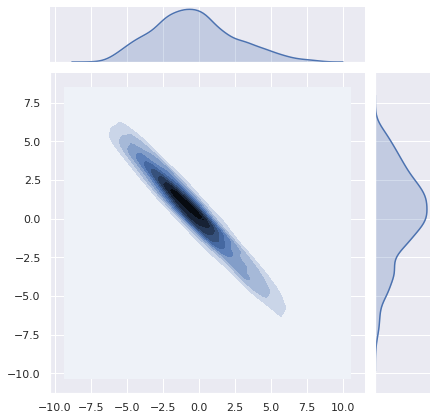

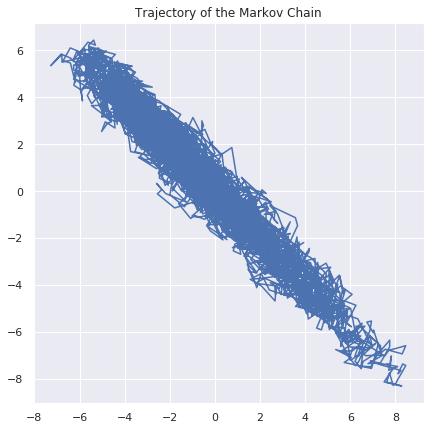

In [9]:
# -- MALA - GAUSSIAN

# Number of sample to generate
nbr_samples = 5000

# MCMC sampler initialization
MALA_GAUSSIAN = MALA(model=GAUSSIAN,
                     metric=torch.eye(2),
                     gradient_step=2e-2,
                     random_step=4e-1,
                     initialization=INIT_POINT)

# Generation of samples
points = MALA_GAUSSIAN.fit(nbr_samples)

# Plot - kde plot takes a few seconds
points = np.array(points)
# plot(points, burnin=0, n_points=nbr_samples-1)
plot(points, burnin=200, n_points=nbr_samples-201, kind='kde')

Of course, one might fight some numerical instability and it would be better to give the log-density to the model rather than the raw density if we have a suitable close form. Fortunatly, we can do so here.

Acceptation ratio : 0.6291682395872656


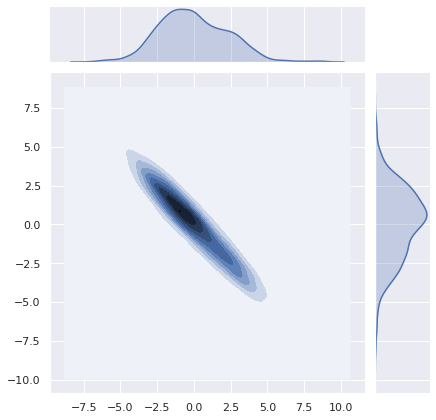

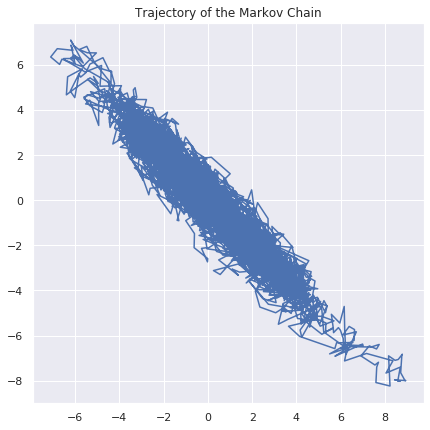

In [12]:
# To avoid scrolling up, we duplicate some code here.

def log_gaussian_torch(mu, sigma):
    def pdf(x):
        return - (x-mu) @ sigma @ (x - mu)
    return pdf

# - GAUSSIAN DISTRIBUTION EXAMPLE
MEAN = torch.zeros(2)
COV = torch.tensor([[1, .9], [.9, 1]])

# Create the model - without known gradient
LOG_GAUSSIAN_DENSITY = log_gaussian_torch(MEAN, COV)
GAUSSIAN = MODEL(log_density=LOG_GAUSSIAN_DENSITY)

# Initial "sample" of the chain
INIT_POINT = 2 * torch.randn_like(MEAN) + 3

# -- MALA - GAUSSIAN

# Number of sample to generate
nbr_samples = 5000

# MCMC sampler initialization
MALA_GAUSSIAN = MALA(model=GAUSSIAN,
                     metric=torch.eye(2),
                     gradient_step=2e-2,
                     random_step=4e-1,
                     initialization=INIT_POINT)

# Generation of samples
points = MALA_GAUSSIAN.fit(nbr_samples)

# Plot - kde plot takes a few seconds
points = np.array(points)
# plot(points, burnin=0, n_points=nbr_samples-1)
plot(points, burnin=200, n_points=nbr_samples-201, kind='kde')